# Location for a new Donut Shop in Madison, WI
#### Jesse Griffiths

## Introduction/Business Problem

The right location is crucial to the success of any venue. Here we'll determine the best location for an aspiring donut shop owner to open shop in Madison, WI. To do this we'll segment the city into distinct regions and examine the prevalence of different venue types in those regions. Then, we'll find a region that is similar to the region with the highest rate of donut shops/bakeries, but doesn't have a high rate itself.

The idea is that venues that do well in one region should also do well in a similar region. We then want to make sure that the donut shop is not in a region that already has many because we want to avoid competition as much as possible.

## Data

We'll be using Fourquare location data for Madison, WI. We'll use the coordinates of each location to calculate the geographic distances between clusters of venues, and segment the city into regions accordingly. For example, this is how we would differenciate between downtown and campus. Then, we'll examine venue types contained in each region to determine the similarity between regions. For example, two regions that have a lot of coffee shops and Indian restaurants would likely be more similar than a region that doesn't have either.

## Methodology

Here's the general outline of what we'll be doing with the data.
1. Segment Madison, WI into regions based on venue locations
2. Determine frequency of venue types for each region
3. Determine similarity of regions based on venue types to find the best region for a new donut shop

### Segment Madison, WI into regions based on venue locations

We'll use Foursquare data to find clusters of venues to define our regions. We'll attempt k-means clustering. If that does not segment the city in a useful way, we'll define the cluster centers manually.

In [2]:
# @hidden_cell
#foursquare credentials
CLIENT_ID = 'MD3ENOTZAGZ3ENYNSSG4OZGDVHROK5Y3C0PUCT44JSBSW4LT'
CLIENT_SECRET = '2GXYWUQDDGFYI2OG4FIWRCKVGROA1XUEJJFLSYFMW124DKYM'
VERSION = '20180605'
LIMIT = 1000

In [3]:
#get the latitude and longitude values of Madison
from geopy.geocoders import Nominatim

mad_address = 'Madison, Wisconsin'

geolocator = Nominatim(user_agent="mad_explorer")
mad_location = geolocator.geocode(mad_address)
mad_lat = mad_location.latitude
mad_long = mad_location.longitude

In [4]:
#create get request url to explore venues in the city
#my credentials were set before in a hidden cell
radius = 8000 #approximate radius of the Madison area
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                          CLIENT_SECRET,
                                                                                                                          VERSION,
                                                                                                                          mad_lat,
                                                                                                                          mad_long,
                                                                                                                          radius,
                                                                                                                          LIMIT)

In [5]:
#send get request
import requests

results = requests.get(url).json()

In [6]:
#function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
#clean json and read it into dataframe
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
    
mad_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
mad_venues = mad_venues.loc[:, filtered_columns]

mad_venues['venue.categories'] = mad_venues.apply(get_category_type, axis=1)

mad_venues.columns = [col.split(".")[-1] for col in mad_venues.columns]

mad_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,Capitol Square,Plaza,43.074593,-89.384379
1,Lucille,Pizza Place,43.074575,-89.381522
2,Dane County Farmers' Market,Farmers Market,43.075337,-89.384996
3,Fromagination,Cheese Shop,43.073491,-89.384832
4,Ian's Pizza on State,Pizza Place,43.074913,-89.386999


In [8]:
#checking the shape of the dataframe
mad_venues.shape

(100, 4)

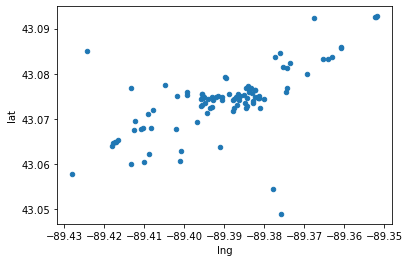

In [9]:
#checking the distribution of the venues pulled to make sure they are somewhat spread out. The image matches the shape of Madison nicely
mad_venues.plot('lng','lat',kind='scatter')

In the above scatterplot we can see two clusters near the center. The one on the left is the college campus, and the one on the right is downtown. When I run k-means to define the regions, these will need to be distinct. That will be the pass/fail condition for using k-means for this purpose.

In [10]:
#run k-means to cluster the venues
#import KMeans
from sklearn.cluster import KMeans

#define number of clusters
kclusters = 10

#drop unnecessary columns
mad_venues_clustering = mad_venues.drop('name', 1)
mad_venues_clustering = mad_venues_clustering.drop('categories', 1)

#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mad_venues_clustering)

In [11]:
#add clustering labels to mad_venues
mad_venues_regions = mad_venues
mad_venues_regions.insert(0, 'Regions', kmeans.labels_)

mad_venues_regions.head()

,Regions,name,categories,lat,lng
0,0,Capitol Square,Plaza,43.074593,-89.384379
1,0,Lucille,Pizza Place,43.074575,-89.381522
2,0,Dane County Farmers' Market,Farmers Market,43.075337,-89.384996
3,0,Fromagination,Cheese Shop,43.073491,-89.384832
4,0,Ian's Pizza on State,Pizza Place,43.074913,-89.386999


In [12]:
#install and import necessary libraries to map regions
!pip install folium
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

     |████████████████████████████████| 94 kB 5.3 MB/s  eta 0:00:01


In [29]:
#map the regions for easier analysis
map_regions = folium.Map(location=[mad_lat, mad_long], zoom_start=13)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(mad_venues_regions['lat'],mad_venues_regions['lng'],mad_venues_regions['name'],mad_venues_regions['Regions']):
    label = folium.Popup(str(poi) + ' Region ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_regions)
       
map_regions

The map above shows that k-means clustering was able to split downtown from campus, which was what I was worried about before. Thankfully, we don't have to go in and manually define regions.

### Determine frequency of venue types for each region

Here we'll use the same Foursquare data to calculate the frequency of each venue type in a region.

In [14]:
#onehot encoding
import pandas as pd
mad_onehot = pd.get_dummies(mad_venues_regions[['categories']], prefix="", prefix_sep="")

mad_onehot['Regions'] = mad_venues_regions['Regions'] 

mad_onehot.set_index('Regions',inplace=True)
mad_onehot.reset_index(inplace=True)

mad_onehot.head()

,Regions,American Restaurant,Asian Restaurant,Bagel Shop,Bakery,Bar,Beach,Breakfast Spot,Brewery,Burger Joint,...,Sandwich Place,Steakhouse,Student Center,Sushi Restaurant,Tapas Restaurant,Trail,Vietnamese Restaurant,Wine Bar,Wine Shop,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the above table each row is a venue with its region along with its type by a 1 in the corresponding column. This will be useful for calculating frequencies of venue types in a region.

In [15]:
#group rows by region and by taking the mean of the frequency of occurrence of each category
mad_grouped = mad_onehot.groupby('Regions').mean().reset_index()
mad_grouped

,Regions,American Restaurant,Asian Restaurant,Bagel Shop,Bakery,Bar,Beach,Breakfast Spot,Brewery,Burger Joint,...,Sandwich Place,Steakhouse,Student Center,Sushi Restaurant,Tapas Restaurant,Trail,Vietnamese Restaurant,Wine Bar,Wine Shop,Zoo
0,0,0.030303,0.030303,0.030303,0.000000,0.060606,0.00,0.00,0.030303,0.00,...,0.030303,0.030303,0.0,0.030303,0.00,0.0,0.000000,0.030303,0.030303,0.000
1,1,0.000000,0.000000,0.000000,0.000000,0.100000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.1,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000
2,2,0.166667,0.000000,0.000000,0.166667,0.000000,0.00,0.00,0.166667,0.00,...,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.166667,0.000000,0.000000,0.000
3,3,0.040000,0.000000,0.000000,0.000000,0.080000,0.00,0.04,0.000000,0.08,...,0.040000,0.000000,0.0,0.000000,0.04,0.0,0.000000,0.000000,0.040000,0.000
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000
5,5,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.125
6,6,0.000000,0.000000,0.000000,0.000000,0.500000,0.25,0.00,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000
7,7,0.000000,0.333333,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000
8,8,0.000000,0.000000,0.000000,0.125000,0.125000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000
9,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.00,1.0,0.000000,0.000000,0.000000,0.000


In the above table each row is a region, and each column shows the frequency of a venue type within that region.

### Determine similarity of regions based on venue types to find the best region for a new donut shop

Here we'll use a nearest-neighbors approach to determine the similarity of different regions.

In [25]:
#define a distance formula (low distance -> high similarity)
#here we use Euclidian distance
from math import sqrt

def regionDifference(regionA, regionB):
    dif = 0
    for i in range(len(regionA)):
        dif = dif + ((regionA[i] - regionB[i])**2)
    return sqrt(dif)

Now that we can find the difference between two regions, let's find the region with the most donut shops/bakeries. Then we can find the regions that are similar.

In [17]:
#take a look at the venue types, so we can find which ones are important to us
mad_grouped.columns

Index(['Regions', 'American Restaurant', 'Asian Restaurant', 'Bagel Shop',
       'Bakery', 'Bar', 'Beach', 'Breakfast Spot', 'Brewery', 'Burger Joint',
       'Café', 'Candy Store', 'Cantonese Restaurant', 'Cheese Shop',
       'Chinese Restaurant', 'Coffee Shop', 'College Basketball Court',
       'College Football Field', 'College Quad', 'Deli / Bodega', 'Diner',
       'Donut Shop', 'Event Space', 'Farmers Market', 'French Restaurant',
       'Garden', 'Gastropub', 'Greek Restaurant', 'Grocery Store',
       'Historic Site', 'Hotel', 'Ice Cream Shop', 'Indie Movie Theater',
       'Indonesian Restaurant', 'Italian Restaurant', 'Lounge',
       'Middle Eastern Restaurant', 'Museum', 'New American Restaurant',
       'Park', 'Pelmeni House', 'Performing Arts Venue', 'Pizza Place',
       'Plaza', 'Pub', 'Record Shop', 'Restaurant', 'Salad Place',
       'Sandwich Place', 'Steakhouse', 'Student Center', 'Sushi Restaurant',
       'Tapas Restaurant', 'Trail', 'Vietnamese Restaurant', '

The columns from the above list that match our needs are Bakery and Donut Shop. Let's see which region has the highest frequency of these.

In [18]:
#frequency of bakeries and donut shops from each region
mad_grouped[['Bakery','Donut Shop']]

,Bakery,Donut Shop
0,0.000000,0.0
1,0.000000,0.1
2,0.166667,0.0
3,0.000000,0.0
4,0.000000,0.0
5,0.125000,0.0
6,0.000000,0.0
7,0.000000,0.0
8,0.125000,0.0
9,0.000000,0.0


Region 1 is the only one that has a donut shop, so this will be the region to compare the other regions to.

## Results

Here we'll calculate the difference from each region to Region 1 to see which is the most similar.

In [26]:
#drop Regions and Donut Shop from the dataframe because we don't want noise from this data to interfere
mad_grouped_no_donut = mad_grouped.drop('Regions',1)
mad_grouped_no_donut = mad_grouped_no_donut.drop('Donut Shop',1)

#convert to lists to use in regionDifference
mad_grouped_no_donut = mad_grouped_no_donut.values.tolist()
mad_grouped_no_donut

#compare every region to Region 1
lowest = 99999
for i in range(len(mad_grouped_no_donut)):
    dif = regionDifference(mad_grouped_no_donut[1],mad_grouped_no_donut[i])
    if dif < lowest:
        if i!=1:
            lowest = dif
            lowest_region = i
        
print("The region with the smallest difference to Region 1 was Region {}".format(lowest_region))

The region with the smallest difference to Region 1 was Region 3


This tells us that the ideal location for a new donut shop is Region 3, because it is the most similar to the only region that has a donut shop.

## Discussion

Region 1 is the west side of the college campus, and Region 3 is the east side. Because of this, it makes sense for business types in one region to exist in the other.

The donut shop in Region 1 is on a busy road that connects downtown Madison to the suburbs. It's also worth noting that the suburbs of Madison are the home of a large tech company with 10,000 young employees, who often live downtown. The high volume of commuters through Region 1 could explain the success of the donut shop, with people coming in to pick up breakfast for themselves and coworkers.

Region 3 connects the campus to the downtown area. It has high foot-traffic with a lot places to stop in and grab quick snacks (ice cream shops, cheese shops, etc.) A donut shop would fit the profile of the region perfectly.

## Conclusion

It's useful to keep symmetries in mind when solving problems such as these. In this example, looking at one side of campus gives us business ideas for the other side. This shows that value in keeping the defining characteristics of a city in mind when planning where to open a business. In general, a city's campuses, lake fronts, downtown areas, etc. can be broken down into sub-regions that can be compared. What's working in one could possibly work in another.